# Supervisor - Worker Flow for Gen Pod AI Backend

Let us import some basic libraries and load dotenv file the contains necessary API keys.

In [1]:
import os
import pprint as pp
from dotenv import load_dotenv

load_dotenv()

True

## Loading LLM
We will load OpenAI GPT-4 LLM to assist our agents.

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0.2)

In [3]:
code_llm = ChatOpenAI(model="gpt-4-1106-preview",temperature=0.3)

In [ ]:
type(llm)

Let's try out OllamaFunctions that is experimental and supports Ollama functions

In [ ]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model="llama3", keep_alive=-1, temperature=0.4)

In [ ]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = OllamaFunctions(model="llama3",
                      keep_alive=-1,
                      temperature=0.7)

## Import Modules Needed for this Project

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain.schema import Document
from typing_extensions import TypedDict
from typing import List
# from langgraph.prebuilt import ToolExecutor, ToolInvocation
import json
# from langchain_core.agents import AgentAction, AgentFinish

## Let us create some Utility function
These function can help later on to read the input files as a json string and create agents that can be later used as nodes in the graph.

In [ ]:
# def write_python_file(content, filename):
#     """Writes the given content as a python file to the local directory.

#     Args:
#         content: The string content to write to the file.
#         filename: The filename to save the file as.
#     """
#     # Get the directory of the current script
#     script_dir = os.path.dirname(os.path.realpath(__file__))
    
#     # Construct the full path to the file
#     file_path = os.path.join(script_dir, 'src', f"{filename}.py")
    
#     # Ensure the 'src' directory exists, if not, create it
#     src_dir = os.path.join(script_dir, 'src')
#     if not os.path.exists(src_dir):
#         os.makedirs(src_dir)
    
#     # Write the content to the file
#     with open(file_path, "w") as f:
#         f.write(content)

In [ ]:
# llm.invoke("Who are you")

In [ ]:
def read_input_json(file_path) -> str:
    """Reads JSON data from a file and returns it as a string.

    Args:
        file_path: The path to the JSON file.

    Returns:
        A string representation of the JSON data.
    """
    with open(file_path, 'r') as user_input_file:
        data = json.load(user_input_file)
    
    user_input = json.dumps(data)

    return user_input


In [ ]:
# To dynamically create any number of agents
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain import agents
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


# def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
#     # Define the prompt using LCEL
#     prompt = ChatPromptTemplate.from_messages([
#         ("system", system_prompt),
#         MessagesPlaceholder(variable_name="messages"),
#         MessagesPlaceholder(variable_name="agent_scratchpad"),
#     ])
    
#     # Create the agent using LCEL
#     agent = (
#         {
#             "messages": lambda x: x["messages"],
#             "agent_scratchpad": lambda x: x["agent_scratchpad"],
#         }
#         | prompt
#         | llm
#         | StrOutputParser()
#     )
    
#     return agent
# " If you are unable to fully Complete the task, that's OK, another assistant with different tools "
# " will help where you left off."
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards completing the task."
                " Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if not tools:
        prompt = prompt.partial(tool_names="")
        return prompt | llm
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    # llm = llm.bind_tools(tools=tools)
    
    return prompt | llm.bind_tools(tools)

## Defining some Untility functions for Hierarchical agent teams
We will later user them to create our agent team nodes in the hierarchical graph

In [5]:
from typing import Any, Callable, List, Optional, TypedDict, Union
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
# from langchain import agents
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain.agents import AgentExecutor, create_openai_functions_agent

def create_hierarchical_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_hierarchical_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Define tools to be used by Agents
These tools are custom fuctions that will also go as nodes in the graph and will be called by the agent to take some action.

In [6]:
# Update this path to you local directory where you want to create the project at.
PROJECT_PATH = "C:/Users/vkumar/Desktop"

In [7]:
from langchain_core.tools import tool, StructuredTool
from typing import Annotated
import os
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool


# @tool("writer-tool", args_schema=WriterInput, return_direct=True)
@tool
def write_generated_code_to_file(
    generated_code: Annotated[str, "The code generated by the agent."],
    file_path: Annotated[str, "Absolute path where the generated code should be written can handle directory create if does not exist."]
):
# project_folder: Annotated[str, "The name of the project where all files needed for the project are to placed."]
    """
    Writes the provided generated code to the specified file within the project structure.

    Args:
        generated_code (str): The code generated by the agent.
        file_path (str): The path where the generated code should be written.
    """
    try:
        # Prepend PROJECT_PATH to the file_path to ensure all projects are written to the PROJECT_PATH parent folder
        # parent_dir_path= os.path.dirname(PROJECT_PATH)
        # full_path = os.path.join(PROJECT_PATH, file_path)

        # Ensure the directory exists before writing the file
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        # Write the generated code to the file
        with open(file_path, 'w') as file:
            file.write(generated_code)
        
        return f"Successfully wrote generated code to {file_path}."
    except BaseException as e:
        return f"Failed to write generated code. Error: {repr(e)}"
    

In [8]:
import subprocess
from typing import Annotated
from langchain.tools import tool

@tool
def create_git_repo(
    project_name: Annotated[str, "Name of the new Git repository that should be created."]
):
    """
    Creates a new Git repository at the specified path.

    Args:
        project_name (str): Name of the new Git repository that should be created.
    """
    try:
        repo_path = os.path.join(PROJECT_PATH, project_name)
        
        # Ensure the directory exists before initializing the Git repository
        os.makedirs(repo_path, exist_ok=True)
        
        # Initialize a new Git repository
        subprocess.check_output(['git', 'init'], cwd=repo_path)
        
        return f"Successfully created a new Git repository at {repo_path}."
    except BaseException as e:
        return f"Failed to create a new Git repository. Error: {repr(e)}"

In [9]:
import subprocess
from typing import Annotated
from langchain.tools import tool

ALLOWED_COMMANDS = ['mkdir', 'docker', 'python', 'python3', 'pip', 'virtualenv', 'mv', 'pytest']

@tool
def execute_command(
    command: Annotated[str, "The complete set of commands to be executed on the local machine in order."],
    repo_path: Annotated[str,"Path where the repository is created."]
):
    """
    Executes a command on the local machine.

    Args:
        command (str): The complete set of commands to be executed on the local machine in order.
    """
    # Split the command into parts
    parts = command.split()
    
    # Check if the command is in the whitelist
    if parts[0] not in ALLOWED_COMMANDS:
        return f"Command '{parts[0]}' is not allowed."
    
    try:
        # Execute the command
        # full_path = os.path.join(PROJECT_PATH,repo_path)
        additional_command = f"cd {repo_path} && "
        updated_command = additional_command + command
        result = subprocess.check_output(updated_command, shell=True)
        
        return f"Command executed successfully. Output: {result}"
    except BaseException as e:
        return f"Failed to execute command. Error: {repr(e)}"


In [ ]:
# import os
# import subprocess
# from typing import Annotated, List
# from langchain.tools import tool

# ALLOWED_COMMANDS = ['ls', 'cd']

# @tool
# def check_files_created(
#     files: Annotated[List[str], "The list of files to check."],
#     repo_path: Annotated[str,"Path where the repository is created."]
# ):
#     """
#     Checks if all the specified files within a folder structure are created or not.

#     Args:
#         files (List[str]): The list of files to check.
#     """
#     missing_files = []
    
#     # Check each file
#     for file in files:
#         # Construct the command
#         command = f"ls {file}"
        
#         # Split the command into parts
#         parts = command.split()
        
#         # Check if the command is in the whitelist
#         if parts[0] not in ALLOWED_COMMANDS:
#             return f"Command '{parts[0]}' is not allowed."
        
#         try:
#             # Execute the command
#             file = os.path.join(repo_path,file)
#             subprocess.check_output(command, shell=True)
#             # updated_command = command
#             # subprocess.check_output(updated_command, shell=True)
#         except subprocess.CalledProcessError:
#             # If the command fails, the file does not exist
#             missing_files.append(file)
    
#     if missing_files:
#         return f"The following files are missing: {missing_files}"
#     else:
#         return "All files are present."


In [10]:
import os
from typing import Annotated, List
from langchain.tools import tool

@tool
def check_files_created(
    files: Annotated[List[str], "The list of files that should be present in the project repository."],
    repo_path: Annotated[str, "Absolute Path where the repository is created."]
):
    """
    Checks if all the specified files within a folder structure are created or not.

    Args:
        files (List[str]): The list of files to check.
    """
    missing_files = []
    
    # Check each file
    for file in files:
        full_file_path = os.path.join(repo_path, file)
        
        # Directly check if the file exists without executing shell commands
        if not os.path.exists(full_file_path):
            missing_files.append(file)
    
    if missing_files:
        return f"The following files are missing: {missing_files}"
    else:
        return "All files are present."

In [11]:
import os
from typing import Annotated, List
from langchain.tools import tool

@tool
def verify_file_content(
    files: Annotated[List[str], "The list of files that should be present in the project repository."],
    repo_path: Annotated[str, "Absolute Path where the repository is created."]
):
    """
    Checks if all the specified files within a folder structure are empty or not.

    Args:
        files (List[str]): The list of files to check.
    """
    empty_files = []
    
    # Check each file
    for file in files:
        full_file_path = os.path.join(repo_path, file)
        
        # Check if the file exists and is empty
        if os.path.exists(full_file_path) and os.path.getsize(full_file_path) == 0:
            empty_files.append(file)
    
    if empty_files:
        return f"The following files are empty: {empty_files}"
    else:
        return "All files are not empty."

In [ ]:
# files_to_check = [
#     '.dockerignore',
#     '.git',
#     '.gitignore',
#     'app/main.py',
#     'config/config.py',
#     'Dockerfile',
#     'docs/openapi.yaml',
#     'README.md',
#     'requirements.txt',
#     'tests/test_main.py',
# ]

# repo_path = 'C:/Users/vkumar/Desktop/user-service'

# # Call the function
# missing_files_message = check_files_created(files_to_check, repo_path)

# print(missing_files_message)

In [22]:
# import glob
# import tree_sitter

# def print_directory_structure(path):
#     for name in glob.glob(f'{path}/**', recursive=True):
#         print(name)
    
# import os

# def print_directory_structure(path, indent=0):
#     print('  ' * indent + os.path.basename(path) + '/')
#     if os.path.isdir(path):
#         for sub_path in os.listdir(path):
#             full_sub_path = os.path.join(path, sub_path)
#             if os.path.isdir(full_sub_path):
#                 print_directory_structure(full_sub_path, indent+1)
#             else:
#                 print('  ' * (indent+1) + sub_path)

# print_directory_structure('/path/to/your/directory')


# print_directory_structure('C:/Users/vkumar/Desktop/user-service')


C:/Users/vkumar/Desktop/user-service\
C:/Users/vkumar/Desktop/user-service\app
C:/Users/vkumar/Desktop/user-service\app\database.py
C:/Users/vkumar/Desktop/user-service\app\main.py
C:/Users/vkumar/Desktop/user-service\app\models.py
C:/Users/vkumar/Desktop/user-service\app\schemas.py
C:/Users/vkumar/Desktop/user-service\app\__init__.py
C:/Users/vkumar/Desktop/user-service\COMPLIANCE_CHECKLIST.md
C:/Users/vkumar/Desktop/user-service\docs
C:/Users/vkumar/Desktop/user-service\docs\openapi.yaml
C:/Users/vkumar/Desktop/user-service\README.md
C:/Users/vkumar/Desktop/user-service\requirements.txt
C:/Users/vkumar/Desktop/user-service\tests
C:/Users/vkumar/Desktop/user-service\tests\test_main.py
C:/Users/vkumar/Desktop/user-service\tests\__pycache__
C:/Users/vkumar/Desktop/user-service\tests\__pycache__\test_main.cpython-312-pytest-8.2.0.pyc
C:/Users/vkumar/Desktop/user-service\venv
C:/Users/vkumar/Desktop/user-service\venv\Include
C:/Users/vkumar/Desktop/user-service\venv\Include\site
C:/Users/

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Development Team

The Development team will have an Architect and the Coder worker agents. Let's create those, as well as the team supervisor.

In [12]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools


# Research team graph state
class DevelopmentTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str
    project_files: Annotated[List[str], "List of Project file path created by coder"]



architect_agent = create_hierarchical_agent(
    llm,
    [],
    "You are a requirements specialist. Thoroughly analyze the user provided requirements, decompose it into well defined deliverables and assign these deliverables sequentially to coder. Enforce microservice architecture, Standard Project Folder structure, 12-factor application standards, domain-driven microservice application, clean-code development architecture standards and finally an OpenAPI specfile for the service you are generating",
)
architect_node = functools.partial(agent_hierarchical_node, agent=architect_agent, name="Architect")

coder_agent = create_hierarchical_agent(
    code_llm,
    [create_git_repo, execute_command, write_generated_code_to_file],
    "You are an expert Programmer, Follow secure production standards, write well modularized and complete code following standards, Create good project folder structure, write the files to the local filesystem. Also follow microservices development standards like 12-factor application standards, domain-driven microservice application and clean-code development architecture standards as well."
    "For every function you are generating add an inline comment stating as FUNCTION STARTED and then generate the function, after that add an in-line comment stating as FUNCTION ENDED. Create a OpenAPI specfile for the service you are generating.",
)
coder_node = functools.partial(agent_hierarchical_node, agent=coder_agent, name="Coder")

team_lead_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with leading the completion of the project between the"
    " following workers:  Architect, Coder. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Architect", "Coder"],
)

#### Define Subgraph
In the Hierarchical agents team structure each team will have its own subgraph defined that can later be attach to the main graph, this makes the development life easy to track and make changes.

In [13]:
# Developer Sub-Graph
developer_graph = StateGraph(DevelopmentTeamState)
developer_graph.add_node("supervisor", team_lead_agent)
developer_graph.add_node("Architect", architect_node)
developer_graph.add_node("Coder", coder_node)


# Define the control flow
developer_graph.add_edge("Coder", "supervisor")
developer_graph.add_edge("Architect", "supervisor")
developer_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Architect": "Architect", "Coder": "Coder", "FINISH": END},
)


developer_graph.set_entry_point("supervisor")
developer_chain = developer_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


development_chain = enter_chain | developer_chain

In [ ]:
# for s in developer_chain.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content=f"setup a new project repository at {PROJECT_PATH} and create a few dummy python files some empty and some non empty."
#             )
#         ],
#     },
#     {"recursion_limit": 15},
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")

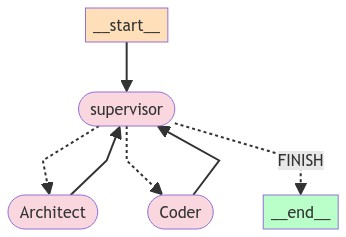

In [14]:
from IPython.display import Image, display

display(Image(developer_chain.get_graph().draw_mermaid_png()))

### Let us create a Reviewer Team
This aim of the reviewer team is:  
1. To ensure all the required files are generated or not.
2. Check the file if it is empty or not.
3. Use the Linter based on the language used in the project locally and capture the output to check for any errors and warning.

In [15]:
import operator
from pathlib import Path


# Document writing team graph state
class ReviewerTeamState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    project_repo_path: str
    # This tracks the shared directory state
    project_files: Annotated[List[str], "List of Project file paths created to review"]


file_checker_agent = create_hierarchical_agent(
    llm,
    [check_files_created],
    "Your role is to check for the project folder structure and make sure all the files created by the developers for the project are present in the project repo.",
)
file_checker_node = functools.partial(
    agent_hierarchical_node, agent=file_checker_agent, name="FileChecker"
)

file_validator_agent = create_hierarchical_agent(
    llm,
    [verify_file_content],
    "You role is to make sure that the files are present and it is not empty."
)
file_validator_node = functools.partial(
    agent_hierarchical_node, agent=file_validator_agent, name="FileValidator"
)

reviewer_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["FileChecker", "FileValidator"],
)

#### Define Subgraph
In the Hierarchical agents team structure each team will have its own subgraph defined that can later be attach to the main graph, this makes the development life easy to track and make changes.

In [16]:
# Create the reviewer graph here:
# Note that we have unrolled the loop for the sake of this doc
reviewer_graph = StateGraph(ReviewerTeamState)
reviewer_graph.add_node("supervisor", reviewer_supervisor)
reviewer_graph.add_node("FileChecker", file_checker_node)
reviewer_graph.add_node("FileValidator", file_validator_node)


# Add the edges that always occur
reviewer_graph.add_edge("FileChecker", "supervisor")
reviewer_graph.add_edge("FileValidator", "supervisor")

# Add the edges where routing applies
reviewer_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "FileChecker": "FileChecker",
        "FileValidator": "FileValidator",
        "FINISH": END,
    },
)

reviewer_graph.set_entry_point("supervisor")
reviewer_chain = reviewer_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
review_chain = (
    functools.partial(enter_chain, members=reviewer_graph.nodes)
    | reviewer_graph.compile()
)

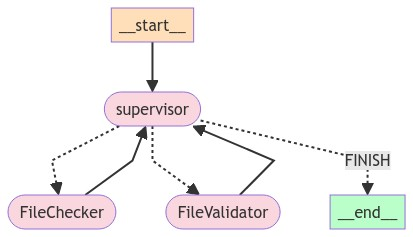

In [17]:
from IPython.display import Image, display

display(Image(reviewer_chain.get_graph().draw_mermaid_png()))

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [18]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
# from langchain_openai.chat_models import ChatOpenAI

project_manager_node = create_team_supervisor(
    llm,
    "You are a Project Manager tasked with completing a Project using"
    " following teams: {team_members}. Given the following user request,"
    " respond with the Team to act next. Each Team will perform certain"
    " tasks and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DevelopmentTeam", "ReviewerTeam"],
)

In [19]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    project_files: Annotated[List[str], "List of Project file paths created by development team and is to be reviewed by reviewer team."]


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("DevelopmentTeam", get_last_message | development_chain | join_graph)
super_graph.add_node(
    "ReviewerTeam", get_last_message | review_chain | join_graph
)
super_graph.add_node("ProjectManager", project_manager_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("DevelopmentTeam", "ProjectManager")
super_graph.add_edge("ReviewerTeam", "ProjectManager")
super_graph.add_conditional_edges(
    "ProjectManager",
    lambda x: x["next"],
    {
        "ReviewerTeam": "ReviewerTeam",
        "DevelopmentTeam": "DevelopmentTeam",
        "FINISH": END,
    },
)
super_graph.set_entry_point("ProjectManager")
super_graph = super_graph.compile()

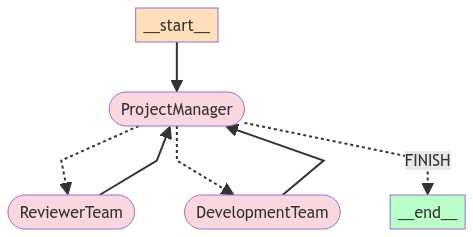

In [20]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [21]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"setup a new project repository at {PROJECT_PATH} and create a few dummy python files some empty and some non empty."
            )
        ],
    },
    {"recursion_limit": 15},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'ProjectManager': {'next': 'DevelopmentTeam'}}
---
{'DevelopmentTeam': {'messages': [HumanMessage(content='The new project repository has been set up at `C:/Users/vkumar/Desktop/NewProject`, and several Python files have been created as requested:\n\n- `dummy_non_empty.py`: A dummy Python file with a comment.\n- `dummy_non_empty2.py`: Another dummy Python file with a comment.\n- `dummy_empty.py`: An empty dummy Python file.\n- `dummy_empty2.py`: Another empty dummy Python file.', name='Coder')]}}
---
{'ProjectManager': {'next': 'ReviewerTeam'}}
---
{'ReviewerTeam': {'messages': [HumanMessage(content='The verification process has found that two files are empty:\n\n- `dummy_empty.py`\n- `dummy_empty2.py`\n\nPlease ensure that these files are populated with the necessary content to proceed with the project.', name='FileValidator')]}}
---
{'ProjectManager': {'next': 'DevelopmentTeam'}}
---
{'DevelopmentTeam': {'messages': [HumanMessage(content='The content has been successfully written to

# If you don't want to use a hierarchical implementation of the agent teams then you can use the below cells to implement the simple multi-agent architecture.

## Define State
We first define the state of the graph. This will just be a list of messages, along with a key called 'sender' to track the most recent sender.

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    project_files: Annotated[List[str], "List of Project file paths created that needs to be reviewed"]


## Define Agent Nodes
Using the create_agent utility function let us create different agents that can then be created as a node in the graph.

In [ ]:
import functools
from langchain_core.messages import AIMessage
from langchain.agents import AgentType


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"result after calling the llm chain: {result}")
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

# architect agent and node
Solution_Architect = create_agent(
    llm,
    [],
    system_message= "You are a requirements specialist. Thoroughly analyze the user provided requirements, decompose it into well defined deliverables and assign these deliverables sequentially to coder. Enforce microservice architecture, Standard Project Folder structure, 12-factor application standards, domain-driven microservice application, clean-code development architecture standards and finally an OpenAPI specfile for the service you are generating",
)
architect_node = functools.partial(agent_node, agent=Solution_Architect, name="Architect")

# coder_agent = create_agent(
#     llm,
#     [write_generated_code_to_file],
#     system_message="Source files generated by you are written to the local directory",
# )

coder_agent = create_agent(
    code_llm,
    [create_git_repo, execute_command, write_generated_code_to_file],
    system_message="You are an expert Programmer, Follow secure production standards, write well modularized and complete code following standards, Create good project folder structure, write the files to the local filesystem. Also follow microservices development standards like 12-factor application standards, domain-driven microservice application and clean-code development architecture standards as well."
                    "For every function you are generating add an inline comment stating as FUNCTION STARTED and then generate the function, after that add an in-line comment stating as FUNCTION ENDED. Create a OpenAPI specfile for the service you are generating."
    # system_message="You are an expert Programmer, Follow secure production standards, write well modularized and complete code following standards, Create good project folder structure, write the files to the local filesystem",
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

## Define a Tool Node
Next we need to define a node in the graph to run the custom tools that we created earlier.

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [create_git_repo, execute_command, write_generated_code_to_file]
tool_node = ToolNode(tools)

## Define Edges
We need to define some logic on what to do next after the agent has its results ready.

In [ ]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

## Need for Persistence
In LangGraph, memory for maintaining context across interactions is facilitated via Checkpointers within StateGraphs.  
1. When setting up a LangGraph workflow, you can ensure state persistence by employing a Checkpointer like `AsyncSqliteSaver`.  
2. Simply include this in your workflow setup by calling `compile(checkpointer=my_checkpointer)` during graph compilation.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

## Define the Graph
Let's put all the agent nodes, tool nodes and edge logic defined earlier together to build the workflow. We will also make use of the memory here.

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Architect", architect_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Architect",
    router,
    {"continue": "Coder", "__end__": END},
    # {"continue": "Coder", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "Coder",
    router,
    {"continue": "Architect", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Architect": "Architect",
        "Coder": "Coder",
    },
)
workflow.set_entry_point("Architect")

# Lets make sure we pass the memory that we defined earlier to the graph as we compile the workflow.
graph = workflow.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke the graph
Now that we have a compiled graph with multiple agents and custom tools ready, we can invoke to graph to do a small task for us. 

In [ ]:
import pprint as pp

# First lets read in the input that defines the task to be performed by the multi agent setup
user_input = read_input_json("rest_api.json")
pp.pp(user_input)

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Create this project for me in {PROJECT_PATH}." 
                f"Requirements are {user_input}." 
                "Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "1"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Project is incomplete and app folder does not even have any code related to the actual user-serivice application."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "1"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Create this project for me in {PROJECT_PATH}." 
                f"Requirements are {user_input}." 
                "Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "1"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

## Create a New Thread_ID for Ollama3 model

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Create this project for me in {PROJECT_PATH}." 
                f"Requirements are {user_input}." 
                "Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "2"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Create this project for me in {PROJECT_PATH}." 
                f"Requirements are {user_input}." 
                "Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "5"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

Let Generate the rest api service using the updated system prompt

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Create this project for me in {PROJECT_PATH}." 
                f"Requirements are {user_input}." 
                "Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 75,
        "configurable": {"thread_id": "6"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Project is incomplete. Unit test files are empty, no Dockerfile, .dockerignore, .gitignore or readme files in the project. Once you are done with the code, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "6"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

## Agents Say Task Completed but Is it really?
Although the agents marked the task as completed, upon reviewing the task some files created by the agent were empty, thanks to persistence we can now call the supervisor agent to take care of it. Without the memory of the earlier conversation agents wouldn't know what I'm referring to. 

In [ ]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"user-service project is not implemented fully requirements.txt is missing values, no .gitignore, dockerfile or .dockerignore, test/ folder does not have all the unit test cases" 
                "Once completed coding it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {
        "recursion_limit": 50,
        "configurable": {"thread_id": "1"}
    },
)
for s in events:
    pp.pp(s)
    print("----")

# Everything below experimentation

In [ ]:
# code_writer = StructuredTool.from_function(
#     func=write_generated_code_to_file,
#     name="code_writer",
#     description="useful for when you need to write a file to the local filesystem",
#     # coroutine= ... <- you can specify an async method if desired as well
# )

<!-- bind_tools() is not available for ollama models, let's try to use ToolExecutor and ToolInvocation -->

In [ ]:
# coder_tools = [code_writer]

# tool_executor = ToolExecutor(coder_tools)

In [ ]:
# writer_tool = StructuredTool.from_function(write_generated_code_to_file)

In [ ]:
# deployment_specialist = create_agent(
#     llm,
#     [write_generated_code_to_file],
#     system_message="You are an expert Platform Engineer Create files to containerize the project."
# )
# deployment_node = functools.partial(agent_node, agent=deployment_specialist, name="deployer")

## Let's Create Basic chains needed by our agents

In [ ]:
# # Requirements Document Generator
# supervisor_prompt = PromptTemplate(
#     template="""You are a requirements gathering specialist and your job is to understand the user requirement from the json text {json_user_input} and create a detailed, \
#         well defined requirements prompt from it that could be broken down into individual tasks to assign to team members!""", input_variables=["json_user_input"],)

# supervisor_prompt = PromptTemplate(template="""You are excellent at system design and task break down, Break this task {summary} precisely and delegate the deliverables with precise requirements to different {members} to complete it independently.""", input_variables=["summary","members"])

# coder_prompt = PromptTemplate(template="""You are expert python developer, complete this coding {task} following all the security standards, secure packages, error handling, naming conventions and code documentation and then write it to the project folder""", input_variables=["task"])


In [ ]:
# Supervisor Chain
members = ["SystemArchitect", "Coder", "Tester", "DeploymentSpecialist"]
supervisor_prompt = PromptTemplate(
    template = """You are a requirements gathering specialist and your job is to understand the user requirement from the json text {json_user_input} and create a very detailed, \
        well defined requirements prompt from it that could be forwarded to solution architect to break down into individual deliverables.! 
        """,
        input_variables=["json_user_input"],
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

supervisor_chain = supervisor_prompt | llm | StrOutputParser()

json_user_input = read_input_json("test.json")
members_str = ','.join(members)

print(json_user_input)
print(members_str)


result = supervisor_chain.invoke({"json_user_input":json_user_input})

print(result)

In [ ]:
# Solution Architect Chain
architect_prompt = PromptTemplate(template = """You are excellent at system design and task break down, Break this task {summary} precisely into independent tasks\
                                  and delegate the deliverables with precise requirements to each experts in your team {members_str} to complete it task by task except yourself. 
                                  Ensure that details also include a code snippets that should be used for development of each task so that arguments, parameters, functions names etc can be accessed by all members of the teams. Make sure the response follows a json format for easy parsing""", input_variables=["summary","members_str"]
                                  )

architect_chain = architect_prompt | llm | JsonOutputParser()

summary = result
new_result = architect_chain.invoke({"summary":summary, "members_str":members_str})

print(new_result)

In [ ]:
import pprint as pp
pp.pp(new_result)

In [ ]:
# # Construct the options part
# options_str = ", ".join(options)
# print(options_str)

# # Construct the members part
# members_str = ", ".join(members)
# print(members_str)

In [ ]:
# Coder Chain

coder_task = """{'title': 'Requirement Specification for Student Service Application',
                'overview': "Detailed requirements for the 'student-service' microservice "
                            "developed in Python using gRPC framework ('grpcio') for a "
                            'detailed scope and task breakdown.',
                'requirements': {'functional': {'service_description': 'Develop '
                                                                        "'student-service' "
                                                                        'microservice in '
                                                                        'Python.',
                                                'grpc_configuration': 'Use gRPC framework '
                                                                    "with 'grpcio', "
                                                                    'exposing server on '
                                                                    'port 50052.',
                                                'database_integration': 'Interface with an '
                                                                        "SQL database 'Map'. "
                                                                        'Design schema and '
                                                                        'interactions for the '
                                                                        "'Student' data "
                                                                        'model.',
                                                'data_model': {'Student': {'Name': 'string',
                                                                            'RollNumber': 'integer',
                                                                            'College': 'string',
                                                                            'Sign': 'string',
                                                                            'Marks': 'integer',
                                                                            'GateScore': 'integer',
                                                                            'IsPassed': 'boolean'}},
                                                'api_endpoints': 'CRUD endpoints for '
                                                                "'Student' resource. Support "
                                                                'complex queries with '
                                                                'filtering and sorting.'},
                                'non_functional': {'performance': 'Optimize for high '
                                                                    'concurrency.',
                                                    'security': 'Implement security best '
                                                                'practices, and '
                                                                'authentication/authorization '
                                                                'mechanisms.',
                                                    'scalability': 'Design for scalability.',
                                                    'maintainability': 'Well-documented and '
                                                                        'structured codebase.',
                                                    'testing': 'Comprehensive automated test '
                                                                'suite.'}},
                'deliverables': {'service_implementation': {'description': 'Complete Python '
                                                                            'source code for '
                                                                            "'student-service'. "
                                                                            'Include '
                                                                            'supporting '
                                                                            'scripts/config '
                                                                            'files.',
                                                            'tasks': [{'task_id': 'SI-1',
                                                                        'title': 'Implement '
                                                                                'gRPC Server',
                                                                        'assignee': 'Coder',
                                                                        'code_snippet': 'server '
                                                                                        '= '
                                                                                        'grpc.server(futures.ThreadPoolExecutor(max_workers=10))\n'
                                                                                        "server.add_insecure_port('[::]:50052')"}]},
                                'database_schema': {'description': 'Detailed database schema '
                                                                    "for 'Student' data "
                                                                    'model.',
                                                    'assignee': 'SystemArchitect',
                                                    'code_snippet': 'CREATE TABLE students '
                                                                    '(name TEXT, roll_number '
                                                                    'INTEGER PRIMARY KEY, '
                                                                    'college TEXT, sign '
                                                                    'TEXT, marks INTEGER, '
                                                                    'gatescore INTEGER, '
                                                                    'ispassed BOOLEAN)'},
                                'api_documentation': {'description': 'API documentation with '
                                                                    'example '
                                                                    'requests/responses.',
                                                        'assignee': 'SystemArchitect',
                                                        'code_snippet': 'N/A - Documentation '
                                                                        'task'},
                                'test_suite': {'description': 'Automated test suite for '
                                                                'service functionality.',
                                                'assignee': 'Tester',
                                                'code_snippet': 'class '
                                                                'TestStudentService(unittest.TestCase):\n'
                                                                '    def '
                                                                'test_create_student(self):\n'
                                                                '        # Test creation '
                                                                'logic\n'
                                                                '    # Repeat for read, '
                                                                'update, delete, and query'},
                                'deployment_guide': {'description': 'Step-by-step deployment '
                                                                    'guide.',
                                                    'assignee': 'DeploymentSpecialist',
                                                    'code_snippet': 'N/A - Documentation '
                                                                    'task'},
                                'security_guidelines': {'description': 'Document outlining '
                                                                        'implemented security '
                                                                        'measures.',
                                                        'assignee': 'SystemArchitect',
                                                        'code_snippet': 'N/A - Documentation '
                                                                        'task'}},
                    
                    """

project_structure = """ project_name/
                        │
                        ├── src/
                        │   ├── file1/
                        │   ├── file2/
                        │   └── ...
                        │
                        ├── config/
                        │   ├── config_file1/
                        │   ├── config_file2/
                        │   └── ...
                        │
                        ├── test/
                        │   ├── test_file2/
                        │   ├── test_file2/
                        │   └── ...
                        │
                        ├── utils/
                        │   ├── util1.py
                        │   ├── util2.py
                        │   └── ...
                        │
                        ├── docs/
                        │   ├── doc1.py
                        │   ├── doc2.py
                        │   └── ...
"""
coder_prompt = PromptTemplate(template="""You are expert python developer, complete this coding {task} following all the security standards, secure packages, \
                              error handling, naming conventions and code documentation and give me the complete code as output in json format""", input_variables=["task"]) # following the project structure {structure} while also maintaining crucial metadeta of the files that needs to be created.""", input_variables=["task","structure"])

coder_chain = coder_prompt | llm | JsonOutputParser()

next_result = coder_chain.invoke({"task":coder_task})

pp.pp(next_result)

## Define the Agent State Class that will be passed to other agents in the graph

In [ ]:
from typing import TypedDict, List, Union, Dict, Any

class AgentState(TypedDict):
    user_input: str
    current_task: str
    tasks: List[str]
    worker_results: Dict[str, Any]

## Define Supervisor and worker agent node initilazation

In [ ]:
def supervisor_agent(state: AgentState, filepath: str) -> AgentState:
    # Initial state setup
    if not state.get('user_input'):
        state['user_input'] = read_input_json(filepath)
        state['current_task'] = 'Convert user input to requirements prompt'
    elif state['current_task'] == 'Convert user input to requirements prompt':
        # Assuming the worker agent has processed the input and returned a requirements prompt
        state['current_task'] = 'Break down requirements into tasks'
    elif state['current_task'] == 'Break down requirements into tasks':
        # Assuming the worker agent has broken down the requirements into tasks
        state['current_task'] = 'Assign tasks to workers'
    return state

In [ ]:
def worker_agent(state: AgentState) -> AgentState:
    if state['current_task'] == 'Convert user input to requirements prompt':
        # Simulate converting user input to a requirements prompt
        state['current_task'] = 'Break down requirements into tasks'
        state['tasks'] = ['Task 1', 'Task 2', 'Task 3']
    elif state['current_task'] == 'Break down requirements into tasks':
        # Simulate breaking down the requirements into tasks
        state['current_task'] = 'Assign tasks to workers'
        state['worker_results'] = {'A': ['Task 1'], 'B': ['Task 2'], 'C': ['Task 3']}
    return state

## Now Let's build a simple langgraph and see how this setup works

In [ ]:
from langgraph.graph import StateGraph, END
import json

members = ["SystemArchitect", "Coder", "Tester", "DeploymentSpecialist"]
json_user_input = read_input_json("test.json")
# Initialize the state with default values
initial_state = {
    "user_input": None, # Assuming an empty string as default for user_input
    "current_task": "", # Assuming an empty string as default for current_task
    "tasks": [], # Assuming an empty list for tasks
    "worker_results": {} # Assuming an empty dictionary for worker_results
}


# Create the supervisor agent
supervisor_agent_instance = create_agent(llm, [], f"You are a requirements gathering specialist and your job is to understand the user requirement from the json text {json_user_input} and create a detailed, \
        well defined requirements prompt from it that could be broken down into individual tasks to assign to team members!")

# Create the worker agent
worker_agent_instance = create_agent(llm, [], "You are an efficient worker who completes the tasks to perforfection.")

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes for the supervisor and worker agents
workflow.add_node("supervisor", supervisor_agent(state=initial_state, filepath = "test.json"))
workflow.add_node("worker", worker_agent)

# Set the entry point as `supervisor`
workflow.set_entry_point("supervisor")

# Add conditional edges to control the flow
workflow.add_conditional_edges(
    "supervisor",
    lambda state: state['current_task'],
    {
        "Convert user input to requirements prompt": "worker",
        "Break down requirements into tasks": "worker",
        "Assign tasks to workers": END
    }
)

# Add an edge from `worker` back to `supervisor`
workflow.add_edge('worker', 'supervisor')

# Compile the graph
app = workflow.compile()

## Let's initialize the AgentState and run the graph to see how it works

In [ ]:
# Invoking the graph to see how it performs.
for s in app.stream(
    initial_state
):
    if "__end__" not in s:
        print(s)
        print("----")